In [1]:
import numpy as np
import ENDFtk
import Angulars
import NDSampler
from NDSampler.angular.Uncertainty_Angular import Uncertainty_Angular
import matplotlib.pyplot as plt
from scipy import stats

tape = ENDFtk.tree.Tape.from_file('/home/pierre/Projects/LIB/JEFF33/26-Fe-56g.jeff33')
mf4mt2 = tape.MAT(tape.material_numbers[0]).MF(4).MT(2).parse()
angulard = tape.materials.front().section(4, 2).parse()
angularu = tape.materials.front().section(34, 2).parse()
uncertainty = Uncertainty_Angular(mf4mt2, angularu, mt_number=2)

_, _, all_mesh, full_cov = Angulars.retrieve_full_covariance_matrix(angularu.reactions[0])

samples = uncertainty.sample_parameters(num_samples=50, sampling_method="Simple", mode="replace")

Creating angular distribution uncertainty for MT2...
Time for extracting coefficients: 0.0067 seconds
Time for extracting covariance matrix: 0.0034 seconds
Full relative covariance matrix shape: (252, 252)
Original matrix size: 252 x 252
Reduced matrix size: 168 x 168
Removed 84 null variance elements
✓ Stored covariance_index_map with 168 entries
Min eigenvalue: -5.935942507507391e-05
Applying trace-preserving positive-definite correction...
  Original matrix:
    Trace: 441.909297
    Min eigenvalue: -5.935943e-05
    Negative eigenvalues: 7
  Corrected matrix:
    Min eigenvalue: 9.999995e-09
    Trace: 441.909297
    Trace preservation: 1.00000000
    Scale factor applied: 0.99999951
  Reduced covariance[:4,:4]:
  [[0.09071996 0.01231999 0.01231999 0.01231999]
 [0.01231999 0.18039991 0.01231999 0.01231999]
 [0.01231999 0.01231999 0.04259998 0.01231999]
 [0.01231999 0.01231999 0.01231999 0.04580998]]
  Reconstructed from L[:4,:4]:
  [[0.09071996 0.01231999 0.01231999 0.01231999]
 [0

# 1. Visualization 

Samples shape: (50, 168)
Energy mesh: 43 boundaries, 42 bins
Legendre orders: 6


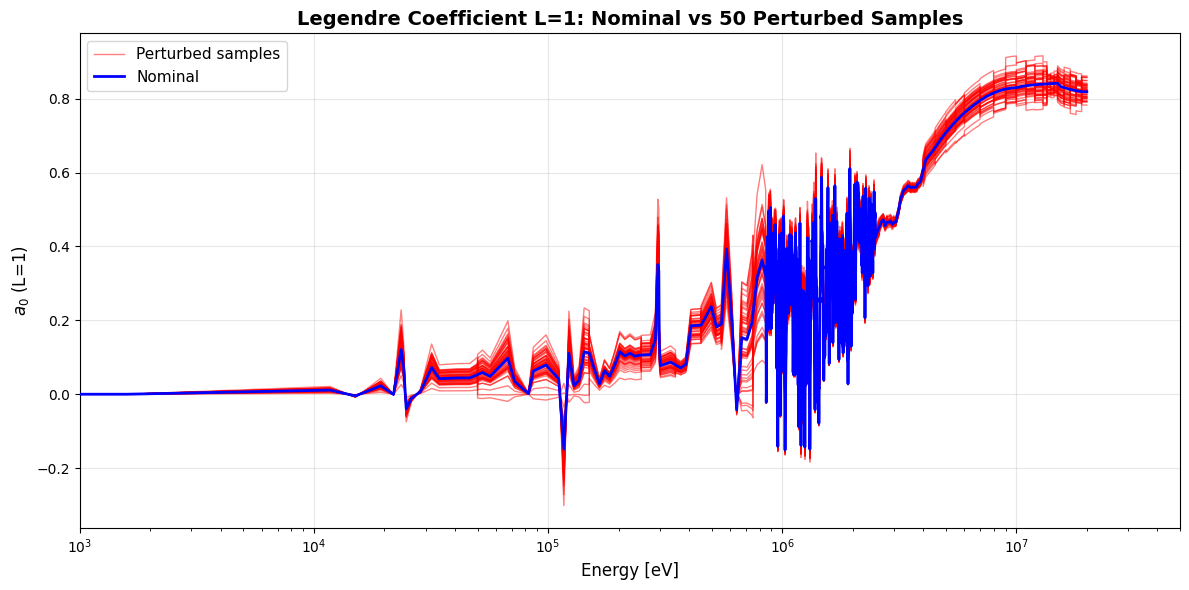

In [2]:
# Plot L=1 (index 0) coefficients using enhanced mesh (mimicking update_tape)
# This creates the union of original MF4 energies and covariance boundaries,
# with proper boundary duplication matching _create_perturbed_legendre_distributions_from_factors

NL = 6
print(f"Samples shape: {samples.shape}")
print(f"Energy mesh: {len(all_mesh)} boundaries, {len(all_mesh)-1} bins")
print(f"Legendre orders: {NL}")

fig, ax = Angulars.plot_perturbed_legendre_coeffs(
    angulard,  # Pass angulard directly
    samples,   # Pass sample matrix
    uncertainty.covariance_index_map, 
    all_mesh,
    legendre_order=0,  # L=1
    max_samples=None,  # Plot all samples
    NL=NL,
    xlim=(1e3, 5e7)
)
plt.show()

## Alternative: Using stored rel_deviation from Uncertainty_Angular

The `Uncertainty_Angular` object stores perturbations in `coeff_data.rel_deviation[sample_index]` after calling `sample_parameters()`. However, this requires the samples to be applied first via `_apply_samples()`. The approach above manually reconstructs the perturbations from the sample matrix.

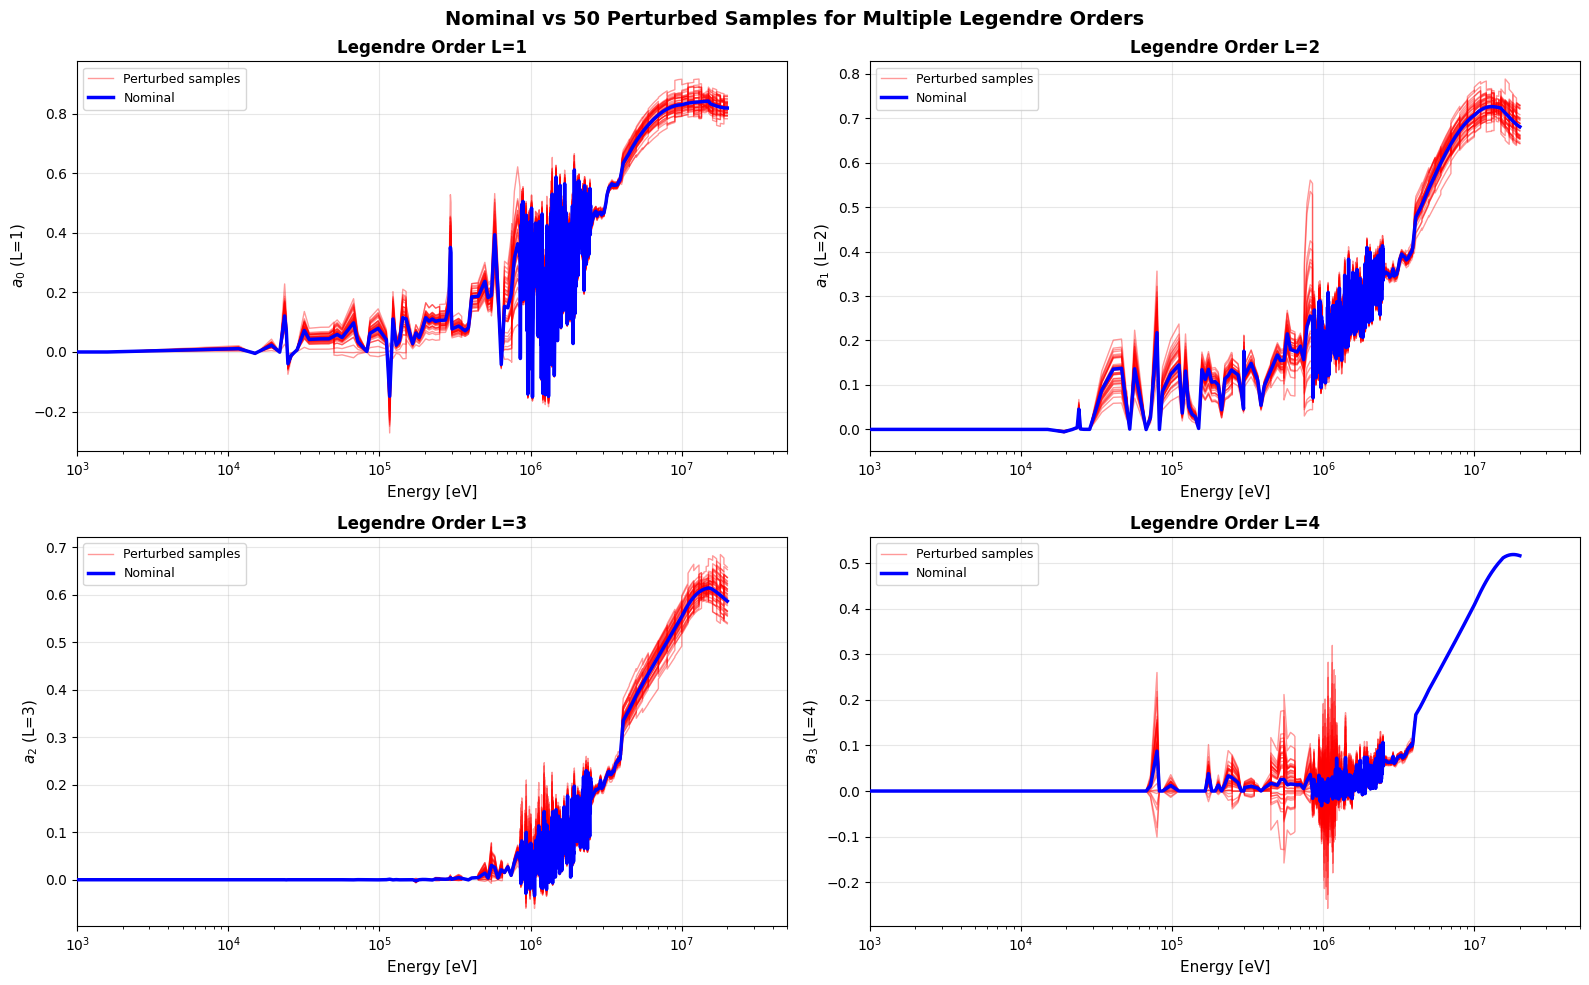

In [3]:
# Optional: Plot multiple Legendre orders (L=1 through L=4) in a grid using enhanced mesh
# Create enhanced distributions once for all plots
enhanced_data_list = Angulars.create_enhanced_legendre_distributions(
    angulard, samples, uncertainty.covariance_index_map, all_mesh, NL=6
)

# Get nominal data
distributions = angulard.distributions.legendre.angular_distributions.to_list()
nominal_energies = [dist.incident_energy for dist in distributions]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

legendre_orders_to_plot = [0, 1, 2, 3]  # L=1, L=2, L=3, L=4
max_samples_to_plot = 40  # Plot all 40 samples

for idx, l in enumerate(legendre_orders_to_plot):
    ax = axes[idx]
    
    # Get nominal coefficients for this order
    nominal_coeffs_l = []
    for dist in distributions:
        coeffs = dist.coefficients[:]
        if l < len(coeffs):
            nominal_coeffs_l.append(coeffs[l])
        else:
            nominal_coeffs_l.append(0.0)
    
    # Plot perturbed samples
    for i in range(min(max_samples_to_plot, len(enhanced_data_list))):
        data = enhanced_data_list[i]
        ax.plot(data['energies'], data['coefficients'][l, :], 
               alpha=0.4, linewidth=1, color='red',
               label='Perturbed samples' if i == 0 else '')
    
    # Plot nominal on top
    ax.plot(nominal_energies, nominal_coeffs_l, 
           'b-', linewidth=2.5, label='Nominal', zorder=100)
    
    ax.set_xscale('log')
    ax.set_xlim(1e3, 5e7)
    ax.set_xlabel('Energy [eV]', fontsize=11)
    ax.set_ylabel(f'$a_{{{l}}}$ (L={l+1})', fontsize=11)
    ax.set_title(f'Legendre Order L={l+1}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Nominal vs {len(enhanced_data_list)} Perturbed Samples for Multiple Legendre Orders', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Mean

Full perturbation shape: (6, 42)
Applied 500 samples to Legendre coefficients


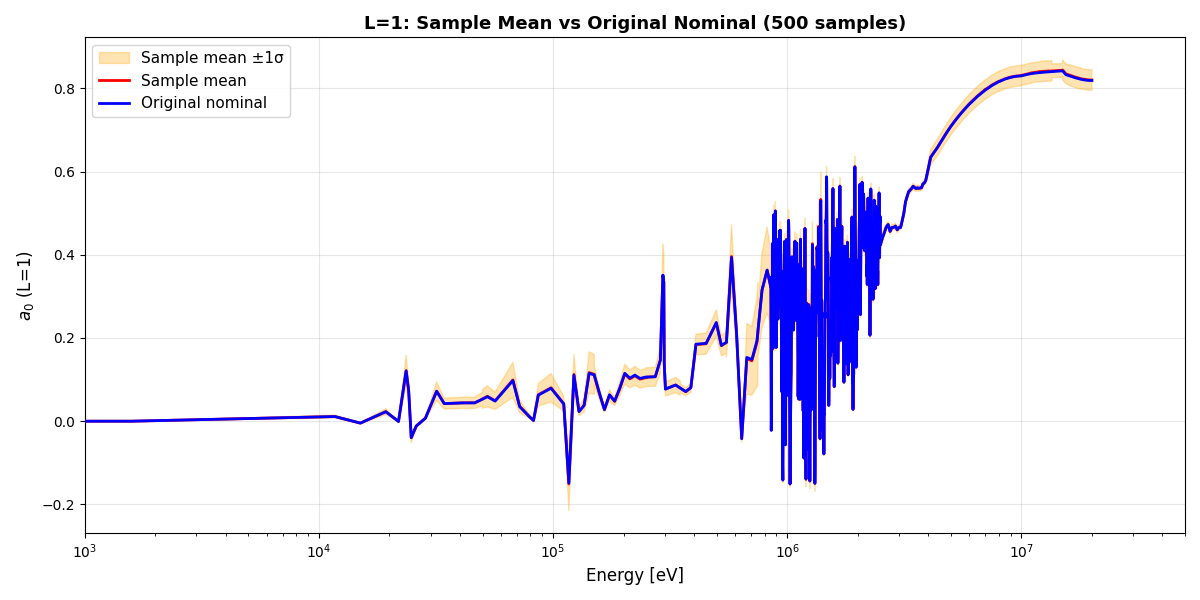

/tmp/ipykernel_164279/4030874341.py:74: RuntimeWarning: invalid value encountered in divide
  rel_bias = bias / np.abs(nominal_at_enhanced)



📊 L=1 Mean Bias Statistics:
  Mean absolute bias:        0.000482
  Mean relative bias:        nan
  Max absolute bias:         0.004653
  RMS bias:                  0.000761
  Average empirical std:     0.014561
  Bias/std ratio (should be small): 0.0331


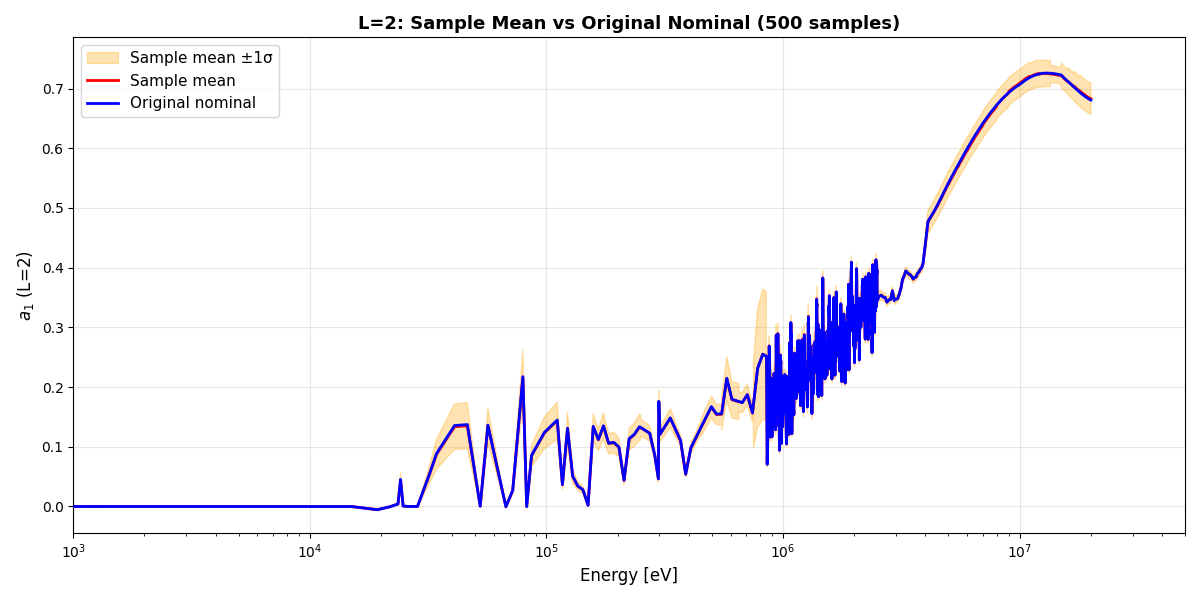


📊 L=2 Mean Bias Statistics:
  Mean absolute bias:        0.000284
  Mean relative bias:        nan
  Max absolute bias:         0.003182
  RMS bias:                  0.000490
  Average empirical std:     0.010223
  Bias/std ratio (should be small): 0.0278


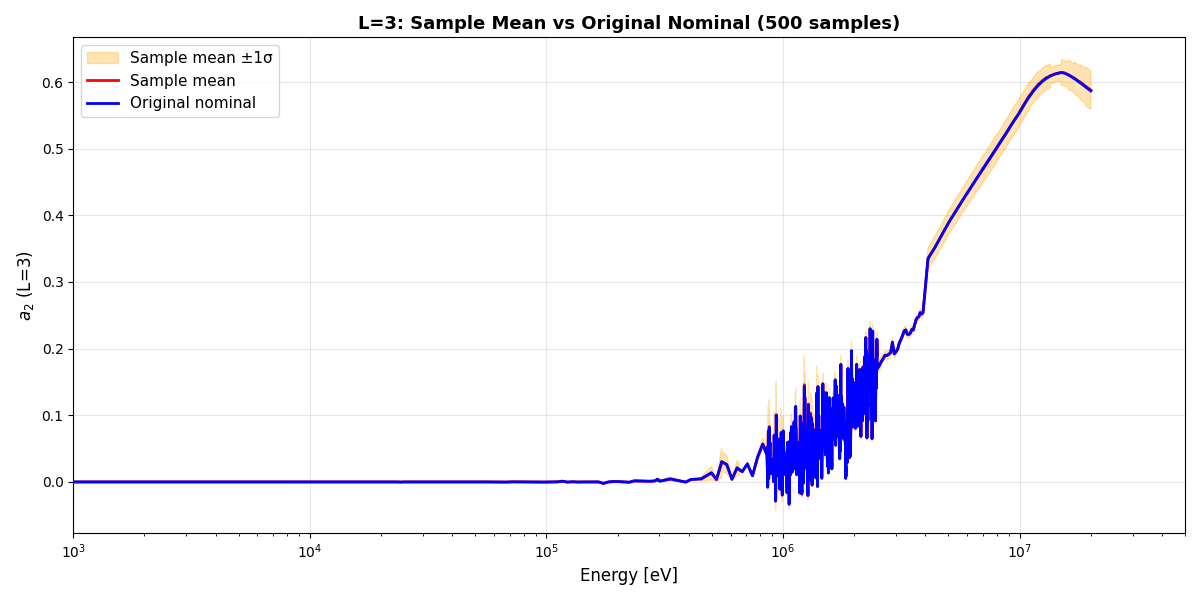


📊 L=3 Mean Bias Statistics:
  Mean absolute bias:        0.000286
  Mean relative bias:        nan
  Max absolute bias:         0.002378
  RMS bias:                  0.000449
  Average empirical std:     0.009670
  Bias/std ratio (should be small): 0.0296


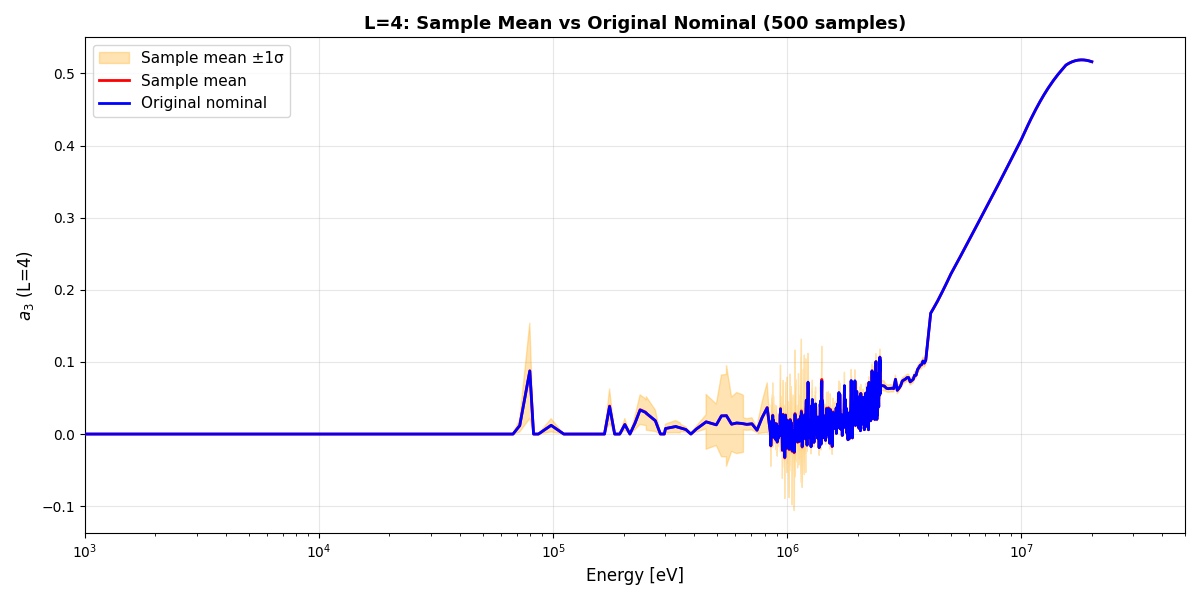


📊 L=4 Mean Bias Statistics:
  Mean absolute bias:        0.000256
  Mean relative bias:        nan
  Max absolute bias:         0.002445
  RMS bias:                  0.000364
  Average empirical std:     0.010757
  Bias/std ratio (should be small): 0.0238


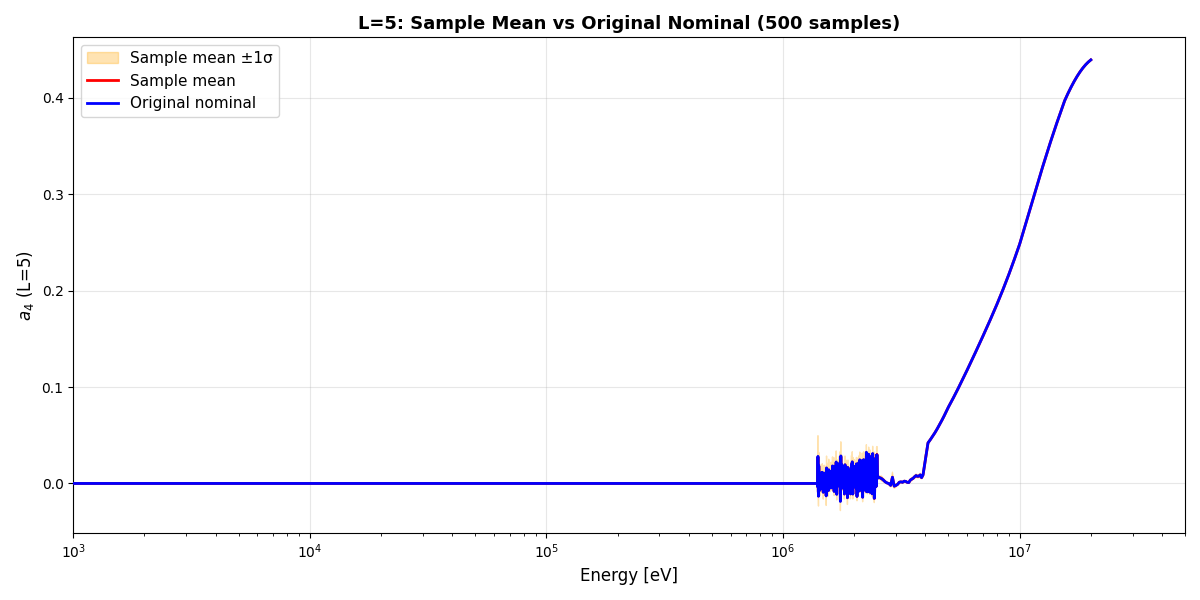


📊 L=5 Mean Bias Statistics:
  Mean absolute bias:        0.000081
  Mean relative bias:        nan
  Max absolute bias:         0.000855
  RMS bias:                  0.000140
  Average empirical std:     0.002135
  Bias/std ratio (should be small): 0.0378


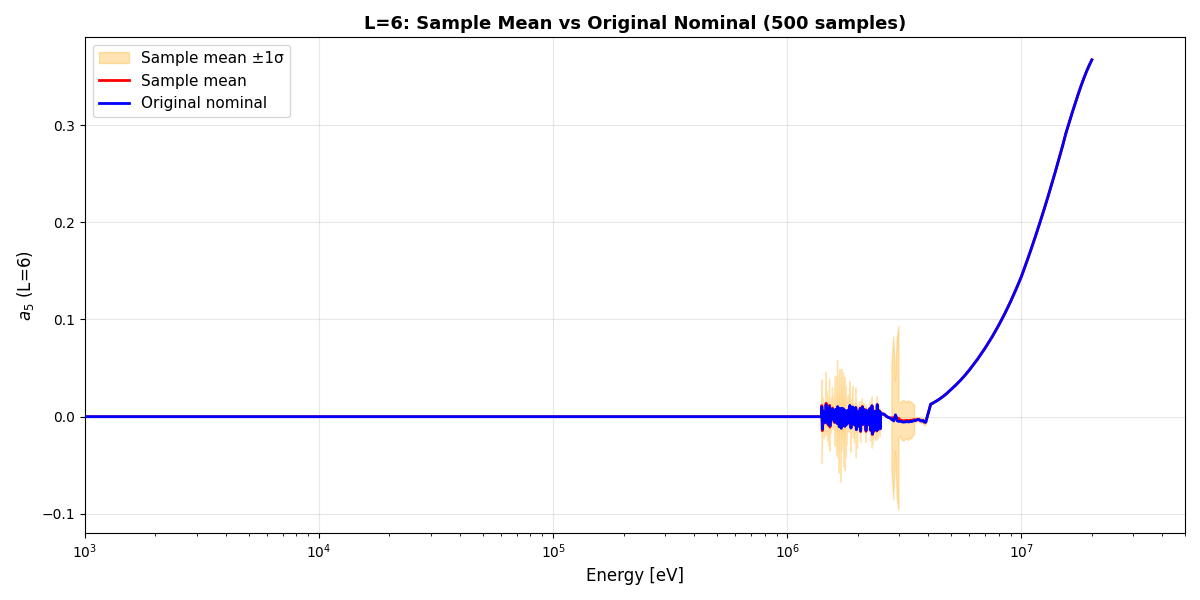


📊 L=6 Mean Bias Statistics:
  Mean absolute bias:        0.000234
  Mean relative bias:        nan
  Max absolute bias:         0.003126
  RMS bias:                  0.000464
  Average empirical std:     0.005379
  Bias/std ratio (should be small): 0.0435


In [4]:
samples = uncertainty.sample_parameters(num_samples=500, sampling_method="Simple", mode="replace")
# Plot sample mean with std deviation vs original nominal
# This verifies that the mean of samples matches the nominal and shows empirical spread
%matplotlib widget
NL = 6

# Create enhanced distributions
enhanced_data_list = Angulars.create_enhanced_legendre_distributions(
    angulard, samples, uncertainty.covariance_index_map, all_mesh, NL=6
)

# Get nominal data from original MF4
distributions = angulard.distributions.legendre.angular_distributions.to_list()
nominal_energies = np.array([dist.incident_energy for dist in distributions])

# Get energies from enhanced data (all samples have same energy grid)
enhanced_energies = enhanced_data_list[0]['energies']

# Plot each Legendre order separately
for l in range(NL):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Get nominal coefficients for this order from original MF4
    nominal_coeffs_l = []
    for dist in distributions:
        coeffs = dist.coefficients[:]
        if l < len(coeffs):
            nominal_coeffs_l.append(coeffs[l])
        else:
            nominal_coeffs_l.append(0.0)
    nominal_coeffs_l = np.array(nominal_coeffs_l)
    
    # Calculate empirical mean and std from enhanced samples
    all_sample_coeffs = np.array([data['coefficients'][l, :] for data in enhanced_data_list])
    empirical_mean = all_sample_coeffs.mean(axis=0)
    empirical_std = all_sample_coeffs.std(axis=0, ddof=1)
    
    # Plot empirical mean with uncertainty band
    upper_emp = empirical_mean + empirical_std
    lower_emp = empirical_mean - empirical_std
    ax.fill_between(enhanced_energies, lower_emp, upper_emp,
                     alpha=0.3, color='orange', label='Sample mean ±1σ', zorder=2)
    
    # Plot sample mean
    ax.plot(enhanced_energies, empirical_mean, 
           'r-', linewidth=2, label='Sample mean', zorder=50)
    
    # Plot nominal on top
    ax.plot(nominal_energies, nominal_coeffs_l, 
           'b-', linewidth=2, label='Original nominal', zorder=100)
    
    ax.set_xscale('log')
    ax.set_xlim(1e3, 5e7)
    ax.set_xlabel('Energy [eV]', fontsize=12)
    ax.set_ylabel(f'$a_{{{l}}}$ (L={l+1})', fontsize=12)
    ax.set_title(f'L={l+1}: Sample Mean vs Original Nominal ({len(enhanced_data_list)} samples)', 
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print mean bias statistics
    # Interpolate nominal onto enhanced energy grid for comparison
    from scipy.interpolate import interp1d
    nominal_interp = interp1d(np.log(nominal_energies), nominal_coeffs_l,
                             kind='linear', bounds_error=False,
                             fill_value=(nominal_coeffs_l[0], nominal_coeffs_l[-1]))
    nominal_at_enhanced = nominal_interp(np.log(enhanced_energies))
    
    # Calculate bias
    bias = empirical_mean - nominal_at_enhanced
    rel_bias = bias / np.abs(nominal_at_enhanced)
    
    print(f"\n📊 L={l+1} Mean Bias Statistics:")
    print(f"  Mean absolute bias:        {np.mean(np.abs(bias)):.6f}")
    print(f"  Mean relative bias:        {np.mean(rel_bias):.6f}")
    print(f"  Max absolute bias:         {np.max(np.abs(bias)):.6f}")
    print(f"  RMS bias:                  {np.sqrt(np.mean(bias**2)):.6f}")
    print(f"  Average empirical std:     {np.mean(empirical_std):.6f}")
    print(f"  Bias/std ratio (should be small): {np.mean(np.abs(bias))/np.mean(empirical_std):.4f}")


# 3. Variance

In [5]:
# Plot 1-sigma error bands: empirical from samples vs original uncertainty
# Compare the uncertainty envelope from covariance matrix with empirical spread from samples
# NOTE: Covariance matrix contains RELATIVE uncertainties

NL = 6

# Create enhanced distributions
enhanced_data_list = Angulars.create_enhanced_legendre_distributions(
    angulard, samples, uncertainty.covariance_index_map, all_mesh, NL=6
)

# Get nominal data from original MF4
distributions = angulard.distributions.legendre.angular_distributions.to_list()
nominal_energies = np.array([dist.incident_energy for dist in distributions])

# Extract covariance mesh
cov_mesh = np.array(all_mesh)

# Extract RELATIVE standard deviations from covariance matrix
rel_std_devs = np.zeros((NL, len(cov_mesh) - 1))
for l in range(NL):
    for i in range(len(cov_mesh) - 1):
        # Find the covariance matrix index for this (L, bin)
        cov_idx = l * (len(cov_mesh) - 1) + i
        if cov_idx < full_cov.shape[0]:
            # Extract RELATIVE standard deviation from covariance matrix
            rel_std_devs[l, i] = np.sqrt(full_cov[cov_idx, cov_idx])

# Create interpolation functions
from scipy.interpolate import interp1d

# Plot each Legendre order separately for better visibility
for l in range(NL):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Get nominal coefficients for this order from original MF4
    nominal_coeffs_l = []
    for dist in distributions:
        coeffs = dist.coefficients[:]
        if l < len(coeffs):
            nominal_coeffs_l.append(coeffs[l])
        else:
            nominal_coeffs_l.append(0.0)
    nominal_coeffs_l = np.array(nominal_coeffs_l)
    
    # Create step function for relative uncertainty (constant within each bin)
    # For each energy, find which covariance bin it falls into
    def get_rel_std_at_energy(energy):
        """Get relative standard deviation at a given energy."""
        # Find which bin this energy falls into
        for i in range(len(cov_mesh) - 1):
            if cov_mesh[i] <= energy < cov_mesh[i+1]:
                return rel_std_devs[l, i]
        # Edge cases
        if energy < cov_mesh[0]:
            return rel_std_devs[l, 0]
        else:
            return rel_std_devs[l, -1]
    
    # Calculate absolute uncertainty at each nominal energy point
    abs_std_at_nominal = np.array([get_rel_std_at_energy(e) * abs(nominal_coeffs_l[i]) 
                                    for i, e in enumerate(nominal_energies)])
    
    # Calculate empirical mean and std from enhanced samples
    all_sample_coeffs = np.array([data['coefficients'][l, :] for data in enhanced_data_list])
    empirical_mean = all_sample_coeffs.mean(axis=0)
    empirical_std = all_sample_coeffs.std(axis=0, ddof=1)
    
    # Get energies from enhanced data (all samples have same energy grid)
    enhanced_energies = enhanced_data_list[0]['energies']
    
    # Plot original covariance uncertainty band (on nominal energy grid)
    upper_cov = nominal_coeffs_l + abs_std_at_nominal
    lower_cov = nominal_coeffs_l - abs_std_at_nominal
    ax.fill_between(nominal_energies, lower_cov, upper_cov,
                     alpha=0.3, color='blue', label='Covariance ±1σ', zorder=1)
    
    # Plot empirical uncertainty band from samples (on enhanced mesh)
    upper_emp = empirical_mean + empirical_std
    lower_emp = empirical_mean - empirical_std
    ax.fill_between(enhanced_energies, lower_emp, upper_emp,
                     alpha=0.3, color='red', label='Empirical ±1σ (samples)', zorder=2)
    
    # Plot nominal on top
    ax.plot(nominal_energies, nominal_coeffs_l, 
           'k-', linewidth=2, label='Nominal', zorder=100)
    
    ax.set_xscale('log')
    ax.set_xlim(1e3, 5e7)
    ax.set_xlabel('Energy [eV]', fontsize=12)
    ax.set_ylabel(f'$a_{{{l}}}$ (L={l+1})', fontsize=12)
    ax.set_title(f'L={l+1}: Covariance vs Empirical Uncertainty ({len(enhanced_data_list)} samples)', 
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for this order
    avg_cov_rel_unc = np.mean(rel_std_devs[l, :])
    avg_emp_rel_unc = np.mean(empirical_std / np.abs(empirical_mean))
    
    print(f"\n📊 L={l+1} Uncertainty Statistics:")
    print(f"  Covariance avg relative uncertainty:  {avg_cov_rel_unc:.4f}")
    print(f"  Empirical avg relative uncertainty:   {avg_emp_rel_unc:.4f}")
    print(f"  Ratio (empirical/covariance):         {avg_emp_rel_unc/avg_cov_rel_unc:.4f}")


KeyboardInterrupt: 